# Popular Data Science Questions

In this guided project, we will try to come up with a topic for a data science article. To do that, we will try to figure out what topic intersts people the most.

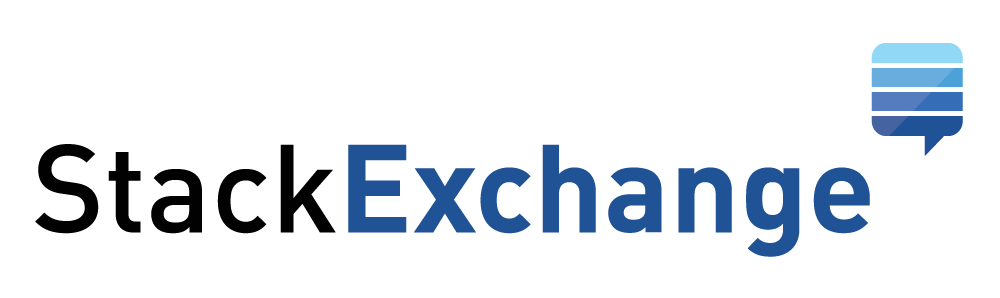

[Stack Exchange](https://stackexchange.com/) hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science. Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

Being a multidisciplinary field, there a few Stack Exchange websites that are relevant to our goal here:

- [Data Science](https://datascience.stackexchange.com/) (DSSE)
- [Cross Validated](https://stats.stackexchange.com/) — a statistics site
- [Artificial Intelligence](https://ai.stackexchange.com/)
- [Mathematics](https://math.stackexchange.com/)
- [Stack Overflow](https://stackoverflow.com/)

And if we want to include Data Engineering, we can also consider:

- [Database Administrators](https://dba.stackexchange.com/)
- [Unix & Linux](https://unix.stackexchange.com/)
- [Software Engineering](https://softwareengineering.stackexchange.com/)

The fact that DSSE is a data science dedicated site (contrarily to the others), coupled with it having a lot of an unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project.

Each question posted on the website is tagged. Tags are one way of categorizing the content of the website and might be useful for our project.

## How to access the data

Stack Exchange provides a public data base for each of its websites. [Here](https://data.stackexchange.com/datascience/query/new)'s a link to query and explore Data Science Stack Exchange's database.

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:

- `Id`: An identification number for the post.
- `PostTypeId`: An identification number for the type of post.
- `CreationDate`: The date and time of creation of the post.
- `Score`: The post's score.
- `ViewCount`: How many times the post was viewed.
- `Tags`: What tags were used.
- `AnswerCount`: How many answers the question got (only applicable to question posts).
- `FavoriteCount`: How many times the question was favored (only applicable to question posts).

Note that with the exception of the tags column, the last few columns contain information about how popular the post is — the kind of information we're after.

Due to their low volume, anything that isn't questions or answers is mostly inconsequential. Even if it happens to be the case that such kind of posts is immensely popular, they would just be outliers and not relevant to us. We'll then just focus on the questions. (At the time of writing it is early 2020).

Since we're only interested in recent posts, we'll limit our analysis to the posts of 2019.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('fivethirtyeight')

import numpy as np

In [96]:
questions = pd.read_csv('2019_questions.csv')

questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [97]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8839 non-null   int64  
 1   CreationDate   8839 non-null   object 
 2   Score          8839 non-null   int64  
 3   ViewCount      8839 non-null   int64  
 4   Tags           8839 non-null   object 
 5   AnswerCount    8839 non-null   int64  
 6   FavoriteCount  1407 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


It looks like the `FavoriteCount` column has a lot of missing data. However, we could fix that by replacing the missing values with 0. That would mean that the post has not been favored.

The `CreationDate` columns is currently not in a datetime format. We need to fix that.

The `Tags` column also needs some cleaning.

## Cleaning the data

In [98]:
#First, let's fill in the NaN with '0':

questions = questions.fillna(0)

In [99]:
#Next, let's convert the `CreationDate` column

questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])

In [100]:
#Next, let's convert the `FavoriteCount` from float to int

questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

#Now we have the columns in the datatype we want:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  8839 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 449.0+ KB


In [101]:
#Next, let's clean the `Tags` column

questions['Tags'] = questions['Tags'].str.replace('><', ',').str.replace('<', '').str.replace('>', '')
questions['Tags'] = questions['Tags'].str.split(',')

questions['Tags'].head()

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object

## Most popular tags

Now that we've cleaned the data, we will focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [102]:
#Let's first see which the most used tags are:

tag_used = {}

for tags in list(questions['Tags']):
    for tag in tags:
        if tag not in tag_used.keys():
            tag_used[tag] = 1
        else:
            tag_used[tag] += 1

tags_used = pd.DataFrame.from_dict(tag_used, orient='index')
tags_used = tags_used.rename(columns={0: 'times_used'})
tags_used = tags_used.sort_values(by='times_used', ascending=False)

tags_used.head()

,times_used
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935


In [103]:
#Now, let's see how many times each tag has been viewed:

tag_views = {}

for x, tags in enumerate(list(questions['Tags'])):
    for tag in tags:
        if tag not in tag_views.keys():
            tag_views[tag] = questions['ViewCount'][x]
        else:
            tag_views[tag] += questions['ViewCount'][x]

views = pd.DataFrame.from_dict(tag_views, orient='index') 
views = views.rename(columns={0:'views'})
views = views.sort_values(by='views', ascending=False)

views.head()

,views
python,537585
machine-learning,388499
keras,268608
deep-learning,233628
pandas,201787


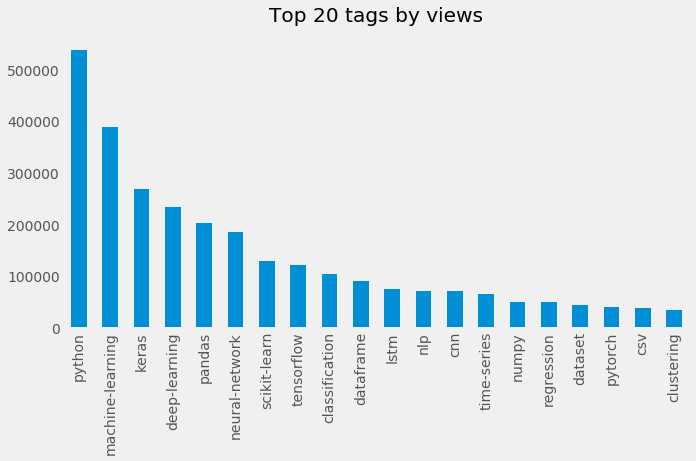

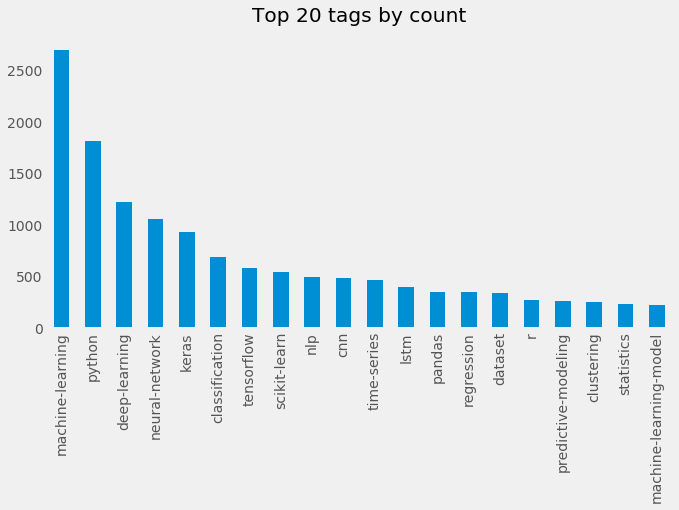

In [104]:
most_viewed = views.head(20)
most_used = tags_used.head(20)

most_viewed.plot(kind='bar', figsize=(10, 5), grid=False, legend=False)
plt.title('Top 20 tags by views', y=1.03)

most_used.plot(kind='bar', figsize=(10, 5), grid=False, legend=False)
plt.title('Top 20 tags by count', y=1.03)
plt.show()

- `most_used` is a dataframe that counts how many times each of the tags was used.
- `most_viewed` is a dataframe that counts how many times each of the tags was viewed.

Let's see what tags are in `most_used`, but not in `most_viewed`.

In [105]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used

,times_used,views
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0
cnn,489,70349.0


Similarly, let's see what tags are in the latter, but not the former:

In [106]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

in_viewed

,times_used,views
python,1814.0,537585
machine-learning,2693.0,388499
keras,935.0,268608
deep-learning,1220.0,233628
pandas,354.0,201787
neural-network,1055.0,185367
scikit-learn,540.0,128110
tensorflow,584.0,121369
classification,685.0,104457
dataframe,NaN,89352


The tags present in `most_used` and not present in `most_viewed` are:

- `machine-learning-model`
- `statistics`
- `predictive-modeling`
- `r`

And the tags present in `most_viewed` but not in `most_used` are:

- `csv`
- `pytorch`
- `dataframe`
- `numpy`

Some tags also stand out as being related. For example, `python` is related to `pandas`, as we can find both python and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

Other pairs of tags, shouldn't be related at all, like `pandas` and `r`:

In [107]:
questions[questions["Tags"].apply(
    lambda tags: True if "r" in tags and "pandas" in tags else False)
]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
2873,60074,2019-09-11 20:35:17,0,22,"[r, pandas, dplyr]",0,0
3651,49148,2019-04-11 19:41:39,1,83,"[r, data-mining, pandas, matlab, databases]",3,0


Just two results. You can look at these questions by replacing `ID` in https://datascience.stackexchange.com/questions/ID with the questions' `Id`s values and see what they are about.

## Favorite count and Answer count

Another way of finding popular tags is to check topics with which tags are favored most often. Also, the higher answer count could also indicate a higher interest for the topic.

In [108]:
f_tags = {}

for x, tags in enumerate(list(questions['Tags'])):
    for tag in tags:
        if tag not in f_tags.keys():
            f_tags[tag] = questions['FavoriteCount'][x]
        else:
            f_tags[tag] += questions['FavoriteCount'][x]
            
favorite_tags = pd.DataFrame.from_dict(f_tags, orient='index')
favorite_tags = favorite_tags.rename(columns={0:'favorite_count'})
favorite_tags = favorite_tags.sort_values(by='favorite_count', ascending=False)
favorite_tags.head(20)

,favorite_count
machine-learning,575
python,325
deep-learning,266
neural-network,227
keras,181
classification,153
scikit-learn,113
cnn,100
time-series,97
nlp,94


In [109]:
a_tags = {}

for x, tags in enumerate(list(questions['Tags'])):
    for tag in tags:
        if tag not in a_tags.keys():
            a_tags[tag] = questions['AnswerCount'][x]
        else:
            a_tags[tag] += questions['AnswerCount'][x]
            
answer_tags = pd.DataFrame.from_dict(a_tags, orient='index')
answer_tags = answer_tags.rename(columns={0:'answer_count'})
answer_tags = answer_tags.sort_values(by='answer_count', ascending=False)
answer_tags.head(20)

,answer_count
machine-learning,2313
python,1507
deep-learning,877
neural-network,824
keras,654
classification,651
scikit-learn,518
pandas,394
nlp,369
cnn,362


In [110]:
top_f = favorite_tags.head(20)
top_a = answer_tags.head(20)

In [111]:
not_in_a = pd.merge(top_f, top_a, how='left', left_index=True, right_index=True)
not_in_a

,favorite_count,answer_count
machine-learning,575,2313.0
python,325,1507.0
deep-learning,266,877.0
neural-network,227,824.0
keras,181,654.0
classification,153,651.0
scikit-learn,113,518.0
cnn,100,362.0
time-series,97,303.0
nlp,94,369.0


In [112]:
not_in_f = pd.merge(top_f, top_a, how='right', left_index=True, right_index=True)
not_in_f

,favorite_count,answer_count
machine-learning,575.0,2313
python,325.0,1507
deep-learning,266.0,877
neural-network,227.0,824
keras,181.0,654
classification,153.0,651
scikit-learn,113.0,518
pandas,42.0,394
nlp,94.0,369
cnn,100.0,362


Three tags from the top 20 most favored tags are not present in the top 20 most answered:

- `image-classification`;
- `feature-engineering`
- `xgboost`

Similarly, three tags from the 20 most answered tags are not present in the top 20 most favored:

- `clustering`
- `r`
- `linear-regression`

What if we tried to combined used, viewed, favored and answered count?

In [113]:
in_all = pd.merge(in_viewed, not_in_f, how='inner', left_index=True, right_index=True)

in_all

,times_used,views,favorite_count,answer_count
python,1814.0,537585,325.0,1507
machine-learning,2693.0,388499,575.0,2313
keras,935.0,268608,181.0,654
deep-learning,1220.0,233628,266.0,877
pandas,354.0,201787,42.0,394
neural-network,1055.0,185367,227.0,824
scikit-learn,540.0,128110,113.0,518
tensorflow,584.0,121369,88.0,353
classification,685.0,104457,153.0,651
lstm,402.0,74458,88.0,244


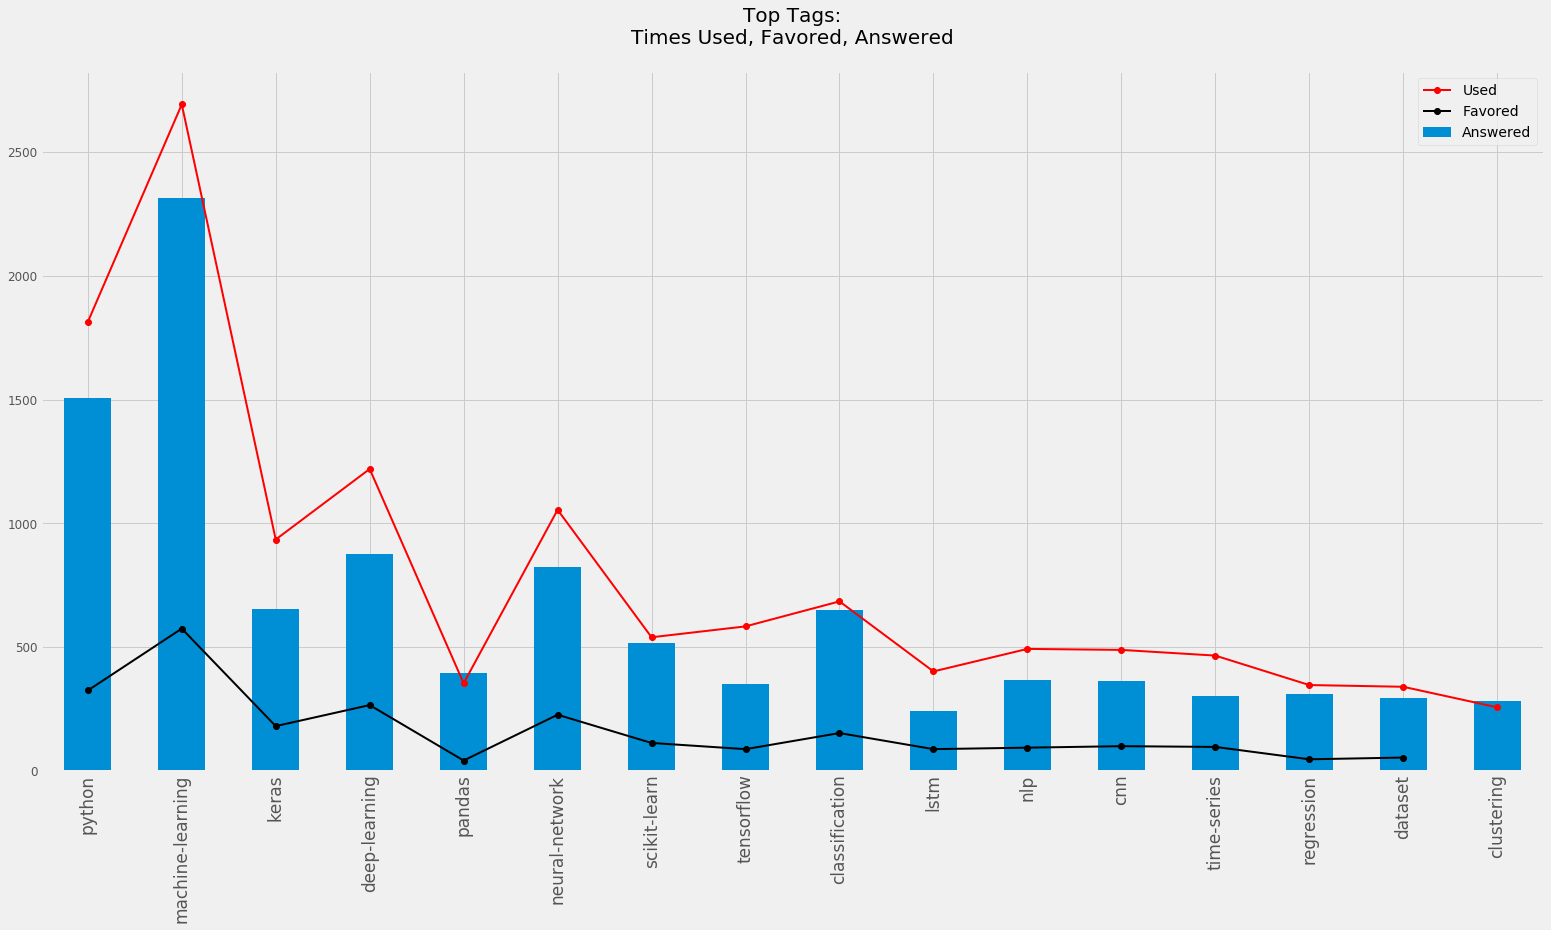

In [114]:
ax1 = in_all.plot(y='times_used', kind='line', figsize=(24,12), linewidth=2, linestyle='-', marker='o', label='Used', color='r')
ax2 = in_all.plot(y='favorite_count', kind='line', ax=ax1, linewidth=2, linestyle='-', marker='o', color='k', label='Favored')
ax3 = in_all.plot(y='answer_count', kind='bar', ax=ax1, fontsize=12, label='Answered', rot=45)
plt.title('Top Tags:\nTimes Used, Favored, Answered', y=1.03, fontsize=20)
plt.xticks(size=17, rotation=90)
plt.show()

## Tags relationship

To find out potential relationship between tags we could:

- review the descriptions of the tags on the [Tags](https://datascience.stackexchange.com/tags) section on the DSSE website
- use the Internet

Most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common and their description: 

- `python` - Use for data science questions related to the programming language Python. Not intended for general coding questions (-> stackoverflow).
- `machine-learning` - Methods and principles of building "computer systems that automatically improve with experience."
- `deep-learning` - a new area of Machine Learning research concerned with the technologies used for learning hierarchical representations of data, mainly done with deep neural networks (i.e. networks with two or more hidden layers), but also with some sort of Probabilistic Graphical Models.
- `neural-network` - Artificial neural networks (ANN), are composed of 'neurons' - programming constructs that mimic the properties of biological neurons. A set of weighted connections between the neurons allows information to propagate through the network to solve artificial intelligence problems without the network designer having had a model of a real system.
- `keras` - a minimalist, highly modular neural network library written in Python. 
- `tensorflow` - TensorFlow is an open source library for machine learning and machine intelligence. TensorFlow uses data flow graphs with tensors flowing along edges. For details, see https://www.tensorflow.org. TensorFlow is released under an Apache 2.0 License.
- `classification` - An instance of supervised learning that identifies the category or categories which a new instance of dataset belongs.
- `scikit-learn` - a Python module comprising of simple and efficient tool for machine learning, data mining and data analysis. It is built on NumPy, SciPy, and matplotlib. It is distributed under the 3-Clause BSD license.

There seems to be a connection between some of the tags. It seems that Python and Machine learning are reoccuring themes of the tags.

## "Is deep learning just a fad?"

Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to SEDE!

The file `all_questions.csv` holds the result of a query which fetches all of the questions ever asked on DSSE, their dates and tags.

To find out, we will:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

In [115]:
all_questions = pd.read_csv('all_questions.csv', parse_dates = ['CreationDate'])

all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [116]:
#Let's clean the Tags column:

all_questions['Tags'] = all_questions['Tags'].str.replace('><', ',').str.replace('<', '').str.replace('>', '')
all_questions['Tags'] = all_questions['Tags'].str.split(',')

all_questions.head()

all_questions = all_questions[all_questions['CreationDate'].dt.year < 2020]

In order to track the interest in Deep learning over time period, let's create a new column 'Period' which would store the quarter and year when the question was raised. This way we will track the interest in the topic over quarters.

In [117]:
def quarter(date):
    year = date.year
    month = date.month
    
    if 1 <= month <=3:
        q = 1
    elif 4 <= month <=6:
        q = 2
    elif 7<= month <=9:
        q = 3
    else:
        q = 4
    return '{}Q{}'.format(year, q)

all_questions['Period'] = all_questions['CreationDate'].apply(quarter)
all_questions.head()

,Id,CreationDate,Tags,Period
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",2019Q1
1,45418,2019-02-12 00:50:39,[neural-network],2019Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",2019Q1
3,45426,2019-02-12 04:51:49,[keras],2019Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",2019Q1


In [118]:
#Let's see which tags appear most often alongside the tag deep-learning
dl_tags = {}

for tags in all_questions['Tags']:
    if 'deep-learning' in tags:
        for tag in tags:
            if tag not in dl_tags.keys():
                dl_tags[tag] = 1
            else:
                dl_tags[tag] += 1

dl_tags_df = pd.DataFrame.from_dict(dl_tags, orient='index')
dl_tags_df = dl_tags_df.rename(columns={0:'count'})
dl_tags_df = dl_tags_df.sort_values(by='count', ascending=False)
dl_tags_df.head(11)

,count
deep-learning,2738
machine-learning,1152
neural-network,914
keras,520
tensorflow,378
python,330
cnn,305
lstm,185
convnet,175
classification,158


Above we see the top 10 tags which apear alongside `deep-learning`. In order to decided whether we need them all, we can consult the [DSSE Tags section](https://datascience.stackexchange.com/tags) and go through the description of each one. After review, we decide to keep the following: ["lstm", "cnn", "tensorflow", "keras", "neural-network", "deep-learning"].

In [119]:
def if_dl(tags):
    dl_tags = ["lstm", "cnn", "tensorflow", "keras", "neural-network", "deep-learning"]
    for tag in tags:
        if tag in dl_tags:
            return 1
    return 0

all_questions['DL'] = all_questions['Tags'].apply(if_dl)

all_questions.head()

,Id,CreationDate,Tags,Period,DL
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",2019Q1,1
1,45418,2019-02-12 00:50:39,[neural-network],2019Q1,1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",2019Q1,0
3,45426,2019-02-12 04:51:49,[keras],2019Q1,1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",2019Q1,0


In [120]:
dl = all_questions.groupby('Period').agg({'DL':['sum', 'size']})
dl.columns=['DL Questions', 'Total']
dl['DL Rate'] = round((dl['DL Questions']/dl['Total'])*100, 2)
dl = dl.reset_index()
dl.head()

,Period,DL Questions,Total,DL Rate
0,2014Q2,7,157,4.46
1,2014Q3,8,189,4.23
2,2014Q4,15,216,6.94
3,2015Q1,14,190,7.37
4,2015Q2,20,284,7.04


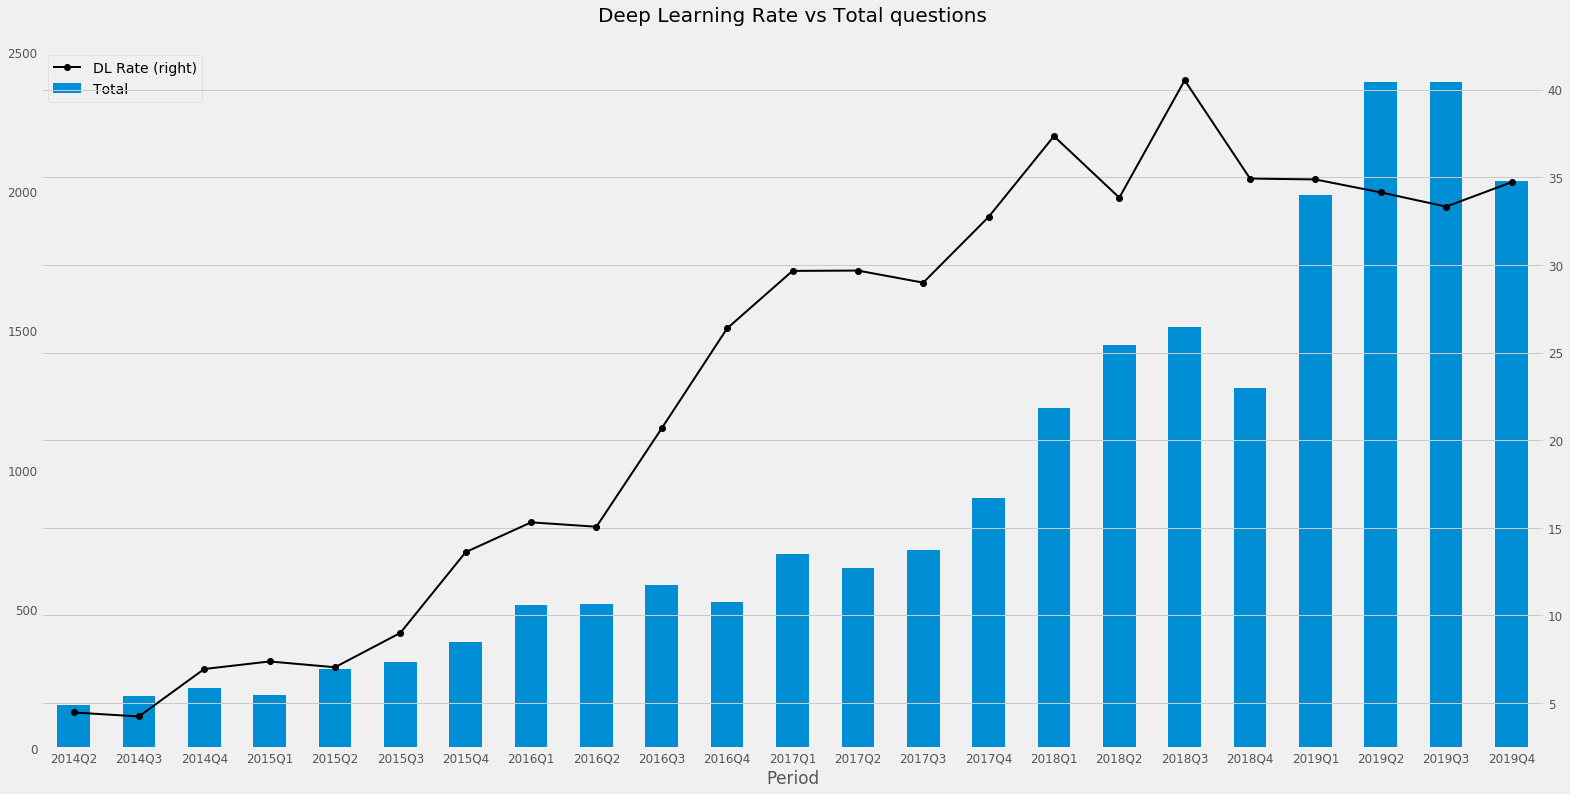

In [121]:
ax1 = dl.plot(x='Period', y='DL Rate', kind='line', color='k', 
              linewidth=2, linestyle='-', marker='o', secondary_y=True, figsize=(24,12), fontsize=12)
ax2 = dl.plot(x='Period', y='Total', kind='bar', rot=45,
              legend=True, ax=ax1, fontsize=12)
plt.title('Deep Learning Rate vs Total questions', y=1.03, fontsize=20)
plt.show()

It looks like the interest in Deep learning has been growing steadily since the introduction of DSSE. It reached it's peak in Q3 of 2018 - 40%. Since then, the interest for the topic has been on a steady 35%. There is no evidence to suggest that the topic is no longer of interest to the users of the site.

## Conclusion

In this project we used data on the questions posted on DESE. We found out which tags used in the topics are most used, viewed, answered and favored. We found out that some of the tags are related (e.g. Python and Pandas), which means that writing an article on one topic could cover more than one of the top tags used on the site.

We also tried to find out if Deep-learning was just a fad. What we found out was the oposite - the interest for the topic has been steady over time.